# Data Mining Term Project - Board Game Geek Rating Prediction/Experimentations
# Student: Kaite (Kurt) Li
# ID: 100 164 5704


# Intention of my Post
## The intention of this post if to illustrate the term project of my Data Mining class. First and foremost, since preproecessing is a huge and necessary part of data mining, this post show step by step on how the preprocessing is done. Also at the end the preprocessing, a breif summary will be provided for the readers to remind what we have accomplished upon till that point. Secondly, a quick data analysis will be provided to see how the data look like after all the preprocessing work, this part gathers good intelligence of the data which we will be working with for the rest of the post. Thirdly, the prediction of the rating based on text comments is awefully similar to our third assignment which we are predicting movie reviews based on text reviews; however, the difference is that the ratings of the board games are continuous numbers from 0 to 10. I am planning on discretizing these ratings so that there are only 11 class labels (0 through 10). After that, I will use sklearn's Multinomial Naive Bayes classifiers to experiment with the data set and gather all the accuracies. My contribution would be implementing ensemble voting, analyze my mechanism, introducing different measurements. Fourthly, I will finalize a ensemble classfier to predict input reviews from outside. Lastly, readers should also read "Important Note" which reveals critical information throughout the post if reader wants to try running the notebook himself.

### Important Note: 
#### Please be patient when you run this notebook, because even after making this notebook as concise as I can, the running time is still very long as we are dealing with multiple classifiers using ensemble over a 2.7 million row data set. Thank you.

# Links
## 1. AnywherePython Flask Webapp Deployment with Serialized Classfier: 
http://kaiteli14.pythonanywhere.com
   
## 2. Github Repo Link (Timestamps): 
https://github.com/kaiteli14/DataMiningTermProject

## 3. Video Demo:
https://www.youtube.com/watch?v=z9A6rye8Elw&feature=youtu.be




# Library Import

## For those of you that are new to Jupyter Notebook, the following section is importing all the library modules. I find it more efficient to keep everything in the same place. Even if I need something new later on in the post, I would always go back here to do the import.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# !pip install Unidecode

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import re
import unidecode
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB as NB
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
import math
from ipywidgets import widgets
from IPython.display import display



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Preprocessing Step: Loading data

## We only need "bbg-13-reviews.csv" file for this project because we are only dealing with rating and comment. Therefore, the rest two .csv files are commented out.

In [2]:
# We are loading all data sets here just in case we need them, but the most important one we are going to be working on is "review_data"/
# game_df = pd.read_csv("boardgamegeek-reviews/2019-05-02.csv")
review_df = pd.read_csv("boardgamegeek-reviews/bgg-13m-reviews.csv")
# game_detail_df = pd.read_csv("boardgamegeek-reviews/games_detailed_info.csv")

# Preprocessing Step: Drop rows that has no comment

## Because we will deal with multiple ratings for our prediciton. If a comment is empty, then there is nothing we can work with and I chose to drop those columns. The other good thing is, dropping the comment will size down the data set and making the run time better.

In [3]:
# Let's take a look at how the data look like before the drop.
review_df.head()

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,Catan
1,1,Varthlokkur,10.0,NaN,13,Catan
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,4,ssmooth,10.0,NaN,13,Catan


In [4]:
# Let's look at the shape of the data before the drop.
review_df.shape

(13170073, 6)

In [5]:
# Let's drop all the rows that has "NaN" in the "comment".
review_df.dropna(subset=["comment"], inplace=True)

In [6]:
# Let's take a look at how the data look like after the drop.
review_df.head()

,Unnamed: 0,user,rating,comment,ID,name
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
7,7,hreimer,10.0,i will never tire of this game.. Awesome,13,Catan
11,11,daredevil,10.0,This is probably the best game I ever played. ...,13,Catan
16,16,hurkle,10.0,Fantastic game. Got me hooked on games all ove...,13,Catan


In [7]:
# Let's look at the shape after the drop.
review_df.shape

(2637756, 6)

# Preprocessing Step: Transform comment into lower case

## Lowering all the comments to a uniform case is a very important step because we would NOT want to see "Word" and "word" be considered as two different features in training.

In [8]:
review_df["comment"] = review_df["comment"].str.lower()

# Preprocessing Step: Remove punctuations

## Similar to the idea above, punctuations are not good features that we should keep. They are for the most part meaningless to our training. Hence, we should just drop them all together.

In [ ]:
# Creating a function for punctuation removal, similar to the one in my practice kaggle notebook.
def functuation_removal(comment):
    return comment.translate(comment.maketrans('','', string.punctuation))

review_df["comment"] = review_df["comment"].apply(lambda comment:functuation_removal(comment))

# Preprocessing Step: Remove url, html, and acceted characters

## All the url, html, and acceted characters are just noise to our training, we should also clear them out here.

In [9]:
def miscellaneous_removal(comment):
    pattern_html = re.compile(r'<.*?>')
    pattern_url = re.compile(r'https?://\S+\www\.\S+')
    comment = pattern_html.sub(r'', comment)
    comment = pattern_url.sub(r'', comment)
    comment = unidecode.unidecode(comment)
    return comment

review_df["comment"] = review_df["comment"].apply(lambda comment: miscellaneous_removal(comment))

# Preprocessing Step: Remove stop words

## In the English language, we will have stop words, such as "to", "of", "by", "for", which are also pointless to the training, we should remove them from the comment to make the data even cleaner.

In [10]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def stop_words_removal(comment):
    return " ".join([word for word in tokenizer.tokenize(comment) if word not in stop_words])

review_df["comment"] = review_df["comment"].apply(stop_words_removal)

## Preprocessing Step: Remove Non English Words

## I found that there are some spanish, russian comments and because the prediction would be in English therefore I do not want other languages show up in the training.

In [11]:
# nltk.download()
words = set(nltk.corpus.words.words())

def remove_non_english_words(comment):
    return " ".join(w for w in nltk.wordpunct_tokenize(comment) if w.lower() in words or not w.isalpha())

review_df["comment"] = review_df["comment"].apply(remove_non_english_words)

# Preprocessing Step: Rounding all ratings

## Since the rating ranges from 0 to 10 and I want to implment Ensemble Voting and Bagging with chosen classfier as Naive Bayes, it is necessary to discretize all the ratings by rounding all of them.

In [12]:
# This works as discretization.
review_df["rating"] = review_df["rating"].round(0).astype(int)

# Preprocessing Step: Remove unnecessary columns

## Remove all columns other than "rating" and "comment"

In [13]:
# Since we are using rating and comment columns to build the prediction model, therefore, we should remove the unnecesarry columns that we do not need.
review_df.drop(review_df.columns[0], axis=1, inplace=True) # This removes the original index column

In [14]:
review_df.drop(review_df.columns[3], axis=1, inplace=True)

In [15]:
review_df.drop(review_df.columns[0], axis=1, inplace=True)

In [16]:
review_df.drop(review_df.columns[2], axis=1, inplace=True)

In [17]:
review_df.head()

,rating,comment
2,10,currently list favorite game
3,10,know many many many uncounted version best
7,10,never tire game awesome
11,10,probably best game ever thinking negotiation
16,10,fantastic game got hooked


# Preprocessing Step: Shuffling rows of the data set

## We are going to split data into train set and test set and because of that the data should be shuffled to make the distribution more even.

In [18]:
review_df = review_df.sample(frac=1).reset_index(drop=True)

# Preprocessing Step: Splitting data set into Train and Test

## Now we do the splitting.

In [19]:
# Transforming DataFrame to Numpy
review_np = review_df.to_numpy()

### Imporant Note: Because the size of the data is to large, the Kaggle Notebook didn't finish for more than an hour; therefore I have to comment out the original "x" and "y" and take a subset of them. Please be aware of this if you want to run it yourself.

In [20]:
# "x" is the comment column of the data and "y" is the rating column of the data
x = review_np[:, 1:]
y = review_np[:, :1]

In [21]:
# Now, let us use skilearn function call to split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [22]:
# Let's look the shape of the data for 
print("-------------------------------------------")
print("The shape of the x_train: ", x_train.shape)
print("The shape of the y_train: ",y_train.shape)
print("-------------------------------------------")
print("The shape of the x_test: ", x_test.shape)
print("The shape of the y_test: ",y_test.shape)
print("-------------------------------------------")

-------------------------------------------
The shape of the x_train:  (2110204, 1)
The shape of the y_train:  (2110204, 1)
-------------------------------------------
The shape of the x_test:  (527552, 1)
The shape of the y_test:  (527552, 1)
-------------------------------------------


### The following is partition of roughly 5% or first 100,000 rows of data to fit our first Naive Bay Classifier.

In [23]:
# Let us try 30% of the original data size and add more later if it is needed. 
# Original shape of x_train, y_train is (2110204, 1) and original shape of x_test, y_test is (527552, 1)

x_train_0, y_train_0 = x_train[:100000, :], y_train[:100000, :]
x_test, y_test = x_test[:150000, :], y_test[:150000, :]

### The following are another two partition are also roughly 5% of the total data size.

In [24]:
x_train_1, y_train_1 = x_train[100000:200000, :], y_train[100000:200000, :]
x_train_2, y_train_2 = x_train[200000:300000, :], y_train[200000:300000, :]

In [25]:
# Let's look the shape of the data for 
print("-------------------------------------------")
print("The shape of the x_train: ", x_train.shape)
print("The shape of the y_train: ",y_train.shape)
print("-------------------------------------------")
print("The shape of the x_test: ", x_test.shape)
print("The shape of the y_test: ",y_test.shape)
print("-------------------------------------------")

-------------------------------------------
The shape of the x_train:  (2110204, 1)
The shape of the y_train:  (2110204, 1)
-------------------------------------------
The shape of the x_test:  (150000, 1)
The shape of the y_test:  (150000, 1)
-------------------------------------------


In [26]:
x_train_0, x_test, y_train_0, y_test = pd.DataFrame(data=x_train_0, columns=["comment"]), pd.DataFrame(data=x_test, columns=["comment"]),\
pd.DataFrame(data=y_train_0, columns=["rating"]), pd.DataFrame(data=y_test, columns=["rating"])

In [27]:
x_train_1, y_train_1 = pd.DataFrame(data=x_train_1, columns=["comment"]), pd.DataFrame(data=y_train_1, columns=["rating"])

In [28]:
x_train_2, y_train_2 = pd.DataFrame(data=x_train_2, columns=["comment"]), pd.DataFrame(data=y_train_2, columns=["rating"])

### Breif Summary at this Point
Understanding a data scientist's job is more than 60% of data preprocessing and also due to the fact that this data set is quite sizable, I have done the following preprocessing steps up on till this point:

1. Remove rows that have no comment, the reason for this is because if the comment is blank, there is nothing we can work with as far as building a predictor is concerned; hence, a removal would be reasonable.
2. Make all comment lower case because this way we won't classify same word into different categories.
3. Punctuations have been removed.
4. Urls, htmls, and accented characters are also removed to make the data even cleaner.
5. Remove all the English stop words.
6. Round all rating from 1 to 10, this is a better way to fit these rating to classfiers while maintain the correct meaning.
7. Remove unnecessary columns.
8. Shuffling all the rows of our data to make it even more natural before analysis and classification.
9. Splitting data into 80% for traning and 20% for testing.


# Data Analysis: View the data after the preprocessing

In [29]:
# Let us look at the head of our data set now.
review_df.head(20)

,rating,comment
0,2,near bottom rank list whim 2012 difficult play...
1,6,neat real time puzzle game multitude difficult...
2,7,sleeved game
3,9,recurring suppressed beyond threshold streets ...
4,6,think nicely done much attractive standard ger...
5,1,interest game
6,7,2Ren Ce Lue Ce Lue Tui Shi You You
7,6,one play exciting might good game develop chil...
8,6,nice little simple grasp pickup deliver game s...
9,7,2 4


In [30]:
# Let us look at the shape of the data at this point.
print(review_df.shape)

(2637756, 2)


# Data Analysis: Rating counts after decretization (0 through 10)

In [31]:
# The following is a rating count from 0 to 10 after making everything discrete.
review_df.groupby(["rating"]).count()

,comment
rating,
0,11
1,20086
2,40766
3,70974
4,136565
5,217766
6,526481
7,574586
8,657581


# Data Analysis: Rating distribution visualized through histogram

Text(0, 0.5, 'Counts')

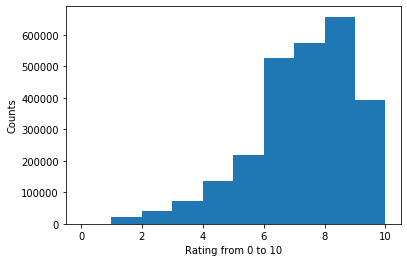

In [32]:
# Histogram for the distribtuion of the rating across 1 to 10.
plt = review_df['rating'].plot.hist()
plt.set_xlabel("Rating from 0 to 10")
plt.set_ylabel("Counts")

# Models - Vectorization

In [33]:
vectorizer = feature_extraction.text.CountVectorizer()
train_vector = vectorizer.fit_transform(x_train_0["comment"])
test_vector = vectorizer.transform(x_test["comment"])

# Models - Naive Bayes Classifiers
### The purpose of this section is to analyze the accuracies of sklearn Multinomial Naive Bayes classifier on our data in numerous ways. The reason I decided to use Naive Bayes classifiers instead of any other classifiers is that rating prediction based on text comment reviews are extremely similar to classification of positive/negative comments based on text comments (I have made my own Naive Bayes model in Assignment 3 which you can see that on my homepage). Since I have preprocessed my data into discrete format (0-10), we can think about the prediction as classification of the data into 11 classes intead of just 2. What I want to achieve and contribute after this section is to use ensemble method to improve accuracy which I learned from this course. I think it is good to try applying in class theory into practice. Furthermore, the entire data has been partitioned into 3 sectors of 33% each for the classifiers. The reason the proportion is decided this way is because this porportion will have accuracy around 31.5% which is very close to the accuracy of 32.6% when we use the entire 2.7 million rows of data. If we cut the data into even smaller pieces,then the accuracy will significantly drops. The whole point is to increase accuracy and we have to very careful when it comes to splitting data for ensemble method.

## First Naive Bayes Classfier Analysis

In [34]:
# We are using MultinomialNB here to check accuracy.
Naive_Bayes_Multinomial = NB()
target_train_vector = np.asarray(y_train_0["rating"], dtype="|S6")
Naive_Bayes_Multinomial.fit(train_vector, target_train_vector)
pred = Naive_Bayes_Multinomial.predict(test_vector)

In [35]:
# If we use the whole 2.7 million rows of data, then the accuracy result is around 30%; however if we use 30% of the whole data, we can still
# achieve an accuraccy of 30% which is not too shaby at all. This is a good thing about Naive Byes With this, we can shorten the run time of all the experiments and also the restart
# needs during the consturction of this notebook by substantial amount.
target_test_vector = np.asarray(y_test["rating"],dtype="|S6")
acc = accuracy_score(target_test_vector,pred)
print("The accuracy for the first Naive Bayes classifier trained over the FIRST 10% of the data is ","{:.2f}".format(acc * 100), "%")

The accuracy for the first Naive Bayes classifier trained over the FIRST 10% of the data is  29.47 %


## Second Naive Bayes Classfier Analysis

In [36]:
vectorizer_1 = feature_extraction.text.CountVectorizer()
train_vector_1 = vectorizer_1.fit_transform(x_train_1["comment"])
test_vector_1 = vectorizer_1.transform(x_test["comment"])

In [37]:
Naive_Bayes_Multinomial_1 = NB()
target_train_vector_1 = np.asarray(y_train_1["rating"], dtype="|S6")
Naive_Bayes_Multinomial_1.fit(train_vector_1, target_train_vector_1)
pred_1 = Naive_Bayes_Multinomial_1.predict(test_vector_1)

In [38]:
target_test_vector_1 = np.asarray(y_test["rating"],dtype="|S6")
acc_1 = accuracy_score(target_test_vector_1,pred_1)
print("The accuracy for the first Naive Bayes classifier trained over the SECOND 10% of the data is ","{:.2f}".format(acc_1 * 100), "%")

The accuracy for the first Naive Bayes classifier trained over the SECOND 10% of the data is  29.38 %


## Third Naive Bayes Classfier Analysis

In [39]:
vectorizer_2 = feature_extraction.text.CountVectorizer()
train_vector_2 = vectorizer_2.fit_transform(x_train_2["comment"])
test_vector_2 = vectorizer_2.transform(x_test["comment"])

In [40]:
Naive_Bayes_Multinomial_2 = NB()
target_train_vector_2 = np.asarray(y_train_2["rating"], dtype="|S6")
Naive_Bayes_Multinomial_2.fit(train_vector_2, target_train_vector_2)
pred_2 = Naive_Bayes_Multinomial_2.predict(test_vector_2)

In [41]:
target_test_vector_2 = np.asarray(y_test["rating"],dtype="|S6")
acc_2 = accuracy_score(target_test_vector_2,pred_2)
print("The accuracy for the first Naive Bayes classifier trained over the LAST 10% of the data is ","{:.2f}".format(acc_2 * 100), "%")

The accuracy for the first Naive Bayes classifier trained over the LAST 10% of the data is  29.47 %


# Contribution - Building my own Ensemble Voting to Test

### Firstly, let's look at all the rows that our 3 classifiers have different prediciton and also the correct prediction from our y_test. The reason for this is because if all 3 classfiers have the same predictions, it does not matter if the prediction is right or wrong that any ensemble voting on 3 identical predictions will still be the same.

In [42]:
for i in range(10):
    if pred[i] == pred_1[i] and pred_1[i] == pred_2[i]:
        continue
    else:
        print("row ", i, ", classfier ONE prediction: ",str(pred[i])[2], ", classfier TWO prediction: ",str(pred_1[i])[2], ", classfier THREE prediction: ",str(pred_2[i])[2],\
              ", correct class is: ", y_test.iloc[i][0])

row  0 , classfier ONE prediction:  7 , classfier TWO prediction:  7 , classfier THREE prediction:  8 , correct class is:  7
row  1 , classfier ONE prediction:  6 , classfier TWO prediction:  6 , classfier THREE prediction:  7 , correct class is:  7
row  3 , classfier ONE prediction:  1 , classfier TWO prediction:  8 , classfier THREE prediction:  9 , correct class is:  10
row  4 , classfier ONE prediction:  1 , classfier TWO prediction:  6 , classfier THREE prediction:  7 , correct class is:  4
row  6 , classfier ONE prediction:  9 , classfier TWO prediction:  8 , classfier THREE prediction:  8 , correct class is:  8
row  8 , classfier ONE prediction:  7 , classfier TWO prediction:  8 , classfier THREE prediction:  6 , correct class is:  5
row  9 , classfier ONE prediction:  7 , classfier TWO prediction:  8 , classfier THREE prediction:  8 , correct class is:  8


### Using ensemble voting over the 3 classifier predictions we have.

### The following section is extracting all the predicitions from all of the 3 sklearn Multinomial Naive Bayes classifiers and average the result to correct error. From a statistical stand point, it is possible some correct answers will be wrongly corrected; however, the goal of the end result is to improve the exisitng classifier accuracy by implementing voting mechanism and bagging data when building the model. Also, by voting, we also close the distance between the prediction rating and the true rating even if we are not right on the rating. 

In [43]:
ensemble_pred = []
for i in range(pred.shape[0]):
    if pred[i] == pred_1[i] and pred_1[i] == pred_2[i]:
        ensemble_pred.append(int(str(pred[i])[2]))
    else:
        temp_sum = int(str(pred[i])[2]) + int(str(pred_1[i])[2]) + int(str(pred_2[i])[2])
        temp_pred = round(temp_sum/3)
        ensemble_pred.append(temp_pred)

In [44]:
# Brief debugg sector to make sure boolean checking goes through.
print(ensemble_pred[1] == y_test.iloc[1][0])

False


In [45]:
total = len(ensemble_pred)
count = 0

for i in range(total):
    if ensemble_pred[i] == y_test.iloc[i][0]:
        count += 1

In [46]:
new_accuracy = count / total
print(new_accuracy)

0.2921533333333333


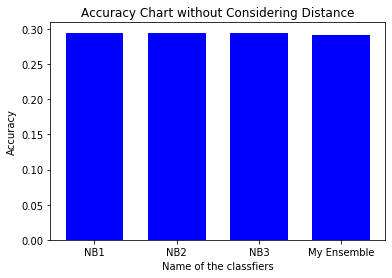

In [47]:
import matplotlib.pyplot as plt
x = [1, 2, 3, 4]
y = [acc, acc_1, acc_2, new_accuracy]
labels = ["NB1", "NB2", "NB3", "My Ensemble"] 
plt.bar(x, y, tick_label = labels, width = 0.7, color = ["blue"]) 
plt.xlabel("Name of the classfiers") 
plt.ylabel("Accuracy") 
plt.title("Accuracy Chart without Considering Distance") 
plt.show() 

### Imporant Note: 
#### because each time you run the model, it shuffles the entire data set before splitting, you sometimes see ensemble voting method being the slightly higher or slightly lesser than the sklearn Multinomial Naive Bayes classfiers, however, this matters not, because next section we will talk about average distance to the true rating which emsemble voting method almost always closes the gap statistically speaking, it would be an ultra rare conincidence that my method here does NOT close the gap.

## As we can see, our implementation in the above section works as expected. The point is that even if the accuracies is extremely similar after doing ensemble voting, it is still better to choose ensemble voting because we have not taken distance into the consideration.

# Contribution - Analysis and Experiment and Undersanding of Distance.
## As we all know by now, the accuracy is constructed in such a way that if the true rating is 9 and even if we predicted a 8 or 10, it is considered wrong. Now, let's assume we have two classifiers, if both of them have the same accuracy, but one's prediction is averagely much more closer to the true rating, do we acknowledge that this predictor to be better? Of course, we do. The purpose here is to realize that accuracy as defined here is not the only measurement of which classifier is better, we should deploy more metrics to analyze the ensemble method and this section devotes to that.

## Here is the average distance of classifier 1 prediction rating to the true rating

In [48]:
total = y_test.shape[0]
total_distance = 0
for i in range(total):
    tmp_pred_rating = int(str(pred[i])[2])
    tmp_true_rating = y_test.iloc[i][0]
    if tmp_pred_rating != tmp_true_rating:
        total_distance += abs(tmp_pred_rating - tmp_true_rating)
    else:
        continue

average_distance_0 = total_distance / total

In [49]:
print("Average distance of the FIRST classfier prediction rating to the true rating: ", average_distance_0)

Average distance of the FIRST classfier prediction rating to the true rating:  1.35906


## Here is the average distance of classifier 2 prediction rating to the true rating

In [50]:
total = y_test.shape[0]
total_distance = 0
for i in range(total):
    tmp_pred_rating = int(str(pred_1[i])[2])
    tmp_true_rating = y_test.iloc[i][0]
    if tmp_pred_rating != tmp_true_rating:
        total_distance += abs(tmp_pred_rating - tmp_true_rating)
    else:
        continue

average_distance_1 = total_distance / total

In [51]:
print("Average distance of the SECOND classfier prediction rating to the true rating: ", average_distance_1)

Average distance of the SECOND classfier prediction rating to the true rating:  1.3527133333333334


## Here is the average distance of classifier 3 prediction rating to the true rating

In [52]:
total = y_test.shape[0]
total_distance = 0
for i in range(total):
    tmp_pred_rating = int(str(pred_2[i])[2])
    tmp_true_rating = y_test.iloc[i][0]
    if tmp_pred_rating != tmp_true_rating:
        total_distance += abs(tmp_pred_rating - tmp_true_rating)
    else:
        continue

average_distance_2 = total_distance / total

In [53]:
print("Average distance of the THRID classfier prediction rating to the true rating: ", average_distance_2)

Average distance of the THRID classfier prediction rating to the true rating:  1.36642


## Here is the average distance of my own ensemble voting prediction rating to the true rating

In [54]:
total = y_test.shape[0]
total_distance = 0
for i in range(total):
    tmp_pred_rating = ensemble_pred[i]
    tmp_true_rating = y_test.iloc[i][0]
    if tmp_pred_rating != tmp_true_rating:
        total_distance += abs(tmp_pred_rating - tmp_true_rating)
    else:
        continue

average_distance_ensemble = total_distance / total

In [55]:
print("Average distance of my ensemble classfier prediction rating to the true rating: ", average_distance_ensemble)

Average distance of my ensemble classfier prediction rating to the true rating:  1.2954733333333333


## Graph of the Average Distance

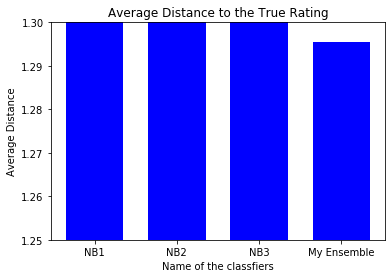

In [58]:
import matplotlib.pyplot as plt
x = [1, 2, 3, 4]
y = [average_distance_0, average_distance_1, average_distance_2, average_distance_ensemble]
labels = ["NB1", "NB2", "NB3", "My Ensemble"] 
plt.bar(x, y, tick_label = labels, width = 0.7, color = ["blue"]) 
plt.xlabel("Name of the classfiers") 
plt.ylabel("Average Distance") 
plt.title("Average Distance to the True Rating") 
plt.ylim(1.25, 1.3)
plt.show() 

## As we can see above, all three Naive Bayes classfiers have very similar average distance to the true rating and my ensemble voting classfier yeild smaller average distance. My point here is, even if the accuracy of my classfier is exactly the same as the sklearn one, we should use my classfier because my average distance to the true rating is smaller by quite a few percent.

# Contribution - New way of defining accuracy incorporating distance measurement.

## Upon till now, we understand that the emsemble voting technique yields lesser average distance to the true rating and I would like to factor this idea into my accuracy calcuation because it would reflect a more truthfully the reality that ensemble voting is indeed worth to use on top of existing methods. Hence, I would consider the prediction accurate if it lands within 1 rating distance to the true rating which is completely reasonable. If you think about a comment stated "this is a great game", how much less accurate am I if I rate it as 9 instead of the true rating 10? Not much, negligible fair to say. Therefore, I will go on and recaculate my result in such way.

## Writing an Auxiliary Function for our Calculation 

In [59]:
def new_accuracy(pred, y_test):
    total = pred.shape[0]
    count = 0
    for i in range(total):
        temp_pred = int(str(pred[i])[2])
        temp_y = y_test.iloc[i][0]
        if temp_pred == temp_y or abs(temp_pred - temp_y) <= 1:
            count += 1
            
    return count / total

## New Accuracy for classfier 1

In [60]:
new_acc = new_accuracy(pred, y_test)
print(new_acc)

0.6566066666666667


## New Accuracy for classfier 2

In [61]:
new_acc_1 = new_accuracy(pred_1, y_test)
print(new_acc_1)

0.66098


## New Accuracy for classfier 3

In [62]:
new_acc_2 = new_accuracy(pred_2, y_test)
print(new_acc_2)

0.65556


## New Accuracy for my Ensemble Voting Clissfier

In [63]:
total = len(ensemble_pred)
count = 0

for i in range(total):
    if ensemble_pred[i] == y_test.iloc[i][0] or abs(ensemble_pred[i] - y_test.iloc[i][0]) <= 1:
        count += 1

new_accuracy = count / total
print(new_accuracy)

0.6679866666666666


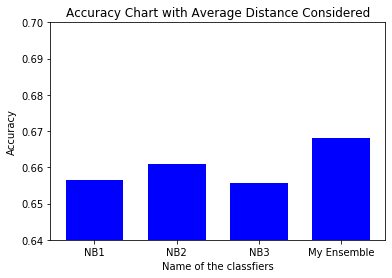

In [64]:
import matplotlib.pyplot as plt
x = [1, 2, 3, 4]
y = [new_acc, new_acc_1, new_acc_2, new_accuracy]
labels = ["NB1", "NB2", "NB3", "My Ensemble"] 
plt.bar(x, y, tick_label = labels, width = 0.7, color = ["blue"]) 
plt.xlabel("Name of the classfiers") 
plt.ylabel("Accuracy") 
plt.title("Accuracy Chart with Average Distance Considered")
plt.ylim(0.64, 0.70)
plt.show() 

## Now with the consideration of the distance into the measurement, almost every time, the ensemble voting classfier beats the sklearn one by a few percents which I consider my way ensemble implementation and understanding to be reasonable at this point in time.

# Contribution - Finish up building my Ensemble Classfier
## This section is to design my ensemble voting classfier and make sure outside intput is predicted when enter through text box.

In [65]:
def ensemble_voting_predict(comment):
    input_np = np.array([[comment]])
    input_df = pd.DataFrame(data=input_np, columns=["comment"])
    input_vector_0 = vectorizer.transform(input_df["comment"])
    input_vector_1 = vectorizer_1.transform(input_df["comment"])
    input_vector_2 = vectorizer_2.transform(input_df["comment"])
    pred_0 = Naive_Bayes_Multinomial.predict(input_vector_0)
    pred_1 = Naive_Bayes_Multinomial_1.predict(input_vector_1)
    pred_2 = Naive_Bayes_Multinomial_2.predict(input_vector_2)
    
#     print(pred_0, pred_1, pred_2)

    rating_0 = int(str(pred_0[0])[2])
    if int(str(pred_0[0])[2]) == 1 and str(pred_0[0])[3] == '0':
        rating_0 = 10
        
    rating_1 = int(str(pred_1[0])[2])
    if int(str(pred_1[0])[2]) == 1 and str(pred_1[0])[3] == '0':
        rating_1 = 10
        
    rating_2 = int(str(pred_2[0])[2])
    if int(str(pred_2[0])[2]) == 1 and str(pred_2[0])[3] == '0':
        rating_2 = 10
        
    final_rating = (rating_0 + rating_1 + rating_2) / 3
    
    return round(final_rating)

# Contribution - Wraping Everything in to my Own Class

## The following section is my finalized EnsembleVoting class which will take x_train, y_train, x_test, y_test in numpy format, a percentage of the portion of the entire data you want to use and the number of Naive Bayes classfiers as need with which my class will split the data accordingly to do the bagging before training them.

In [66]:
class EnsembleVoting:
    # x_train, y_train, x_test, and y_test are all
    def __init__(self, x_train, y_train, x_test, y_test, use_percentage=1, num_of_classifier=3):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.num_of_classifier = num_of_classifier
        self.upper_index = math.ceil(x_train.shape[0] * use_percentage)
        self.increment = math.ceil(self.upper_index / num_of_classifier)
        self.x_df_container = []
        self.y_df_container = []
        self.vectorizers = self.instantiate_vectorizers()
        self.naive_bayes = self.instantiate_naive_bayes()
    
    def fit_all_naive_bayes(self):
        for i in range(self.num_of_classifier):
            train_vector = self.vectorizers[i].fit_transform(self.x_df_container[i]["comment"])
            target_train_vector = np.asarray(self.y_df_container[i]["rating"], dtype="|S6")
            self.naive_bayes[i].fit(train_vector, target_train_vector)
    
    def instantiate_naive_bayes(self):
        naive_bayes = []
        for i in range(self.num_of_classifier):
            t_naive_bayes = NB()
            naive_bayes.append(t_naive_bayes)
        
        return naive_bayes
    
    def instantiate_vectorizers(self):
        vectorizers = []
        for i in range(self.num_of_classifier):
            t_vectorizer = feature_extraction.text.CountVectorizer()
            vectorizers.append(t_vectorizer)
        
        return vectorizers
        
    def groom_data(self):
        split_indices = [0]
        current_index = 0
        while(True):
            current_index += self.increment
            if current_index <= self.upper_index:
                split_indices.append(current_index)
            else:
                split_indices.append(self.upper_index)
                break;
                
        for i in range(len(split_indices)-1):
            l = i
            r = i + 1
            t_x_train, t_y_train = self.x_train[split_indices[l]:split_indices[r], :], self.y_train[split_indices[l]:split_indices[r], :]
            t_x_train, t_y_train = pd.DataFrame(data=t_x_train, columns=["comment"]), pd.DataFrame(data=t_y_train, columns=["rating"])
            self.x_df_container.append(t_x_train)
            self.y_df_container.append(t_y_train)
    
    def ensemble_voting_predict(self, comment):
        input_np = np.array([[comment]])
        input_df = pd.DataFrame(data=input_np, columns=["comment"])
        ratings = []
        
        for i in range(self.num_of_classifier):
            t_input_vector = self.vectorizers[i].transform(input_df["comment"])
            t_pred = self.naive_bayes[i].predict(t_input_vector)
            rating = int(str(t_pred[0])[2])
            
            if int(str(t_pred[0])[2]) == 1 and str(t_pred[0])[3] == '0':
                rating = 10
            
            ratings.append(rating)
            
        return round(sum(ratings) / len(ratings))
        
    
    # Here is my effort to attempt to convert this into webapp(extra credit), have to clear all data first, and then serialize it and then just use the trained
    # classifiers for the app program as there is size requirement from PythonAnyWhere
    def clear_data_set(self):
        self.x_train, self.y_train, self.x_test, self.y_test = None, None, None, None
        self.x_df_container, self.y_df_container = None, None
    

## Instantiate my class, groom the input data, and fit all the naive bayes classifiers in my ensemblevoting class

In [67]:
EV = EnsembleVoting(x_train, y_train, x_test, y_test, use_percentage=1)
EV.groom_data()
EV.fit_all_naive_bayes()

In [68]:
# This step is not in Kaggle, this is a step in serialization for the webapp after everything is trained.
EV.clear_data_set()

In [69]:
# This step is not in Kaggle, this is a step in serialization for the webapp after everything is trained.
# import pickle
# with open('EV.txt', 'wb') as fh:
#     pickle.dump(EV, fh)

In [70]:
# from sklearn.externals import joblib
# if __name__ == "__main__":
#     joblib.dump(EV, 'EV.pkl')

## Predicting my demonstration comments before doing the actual demonstration.

In [73]:
print("Sample prediction of my EnsembleVoting classfier: ", EV.ensemble_voting_predict("this game is so wonderful, the best game i have ever played."))

Sample prediction of my EnsembleVoting classfier:  10


# Contribution - Demonstration Section

## I will try my hardest to use serialization to achieve the transition from local host to webapp, but in case the extra credit attempt doesn't work out, here is my demonstration interface for my EnsembleVoting class. UPDATE: After spending 12 hours of debugging, I finally am able to deploy my classfier to make prediction live.

## Besides the Web App, the following is a Juypter/Kaggle Notebook widget that we can use to test the predictor.

In [72]:
input_field = widgets.Text()
display(input_field)
output_field = widgets.Text(disabled=True)
display(output_field)
predict_button = widgets.Button(description="Predict Rating")
display(predict_button)
clear_button = widgets.Button(description="Clear Entry")
display(clear_button)



def handle_enter(sender):
    rating = EV.ensemble_voting_predict(input_field.value)
    output_field.value = str(rating)

def handle_clear(v):
    input_field.value = ''
    output_field = ''

input_field.on_submit(handle_enter)
predict_button.on_click(handle_enter)
clear_button.on_click(handle_clear)

Text(value='')

Text(value='', disabled=True)

Button(description='Predict Rating', style=ButtonStyle())

Button(description='Clear Entry', style=ButtonStyle())

# Conclusion and Challenges
## Truth be told, I have spent weeks of work on this project. From brainstorming ideas on how to do this project, incrementally refining the data, trying out different methods before deciding on implementing ensemble voting mechanism to better the sklearn Naive Bayes classifier to finally writing everything and also making sure I give the extra mile of effort by implementing extra credit portion of the requirement which is Flask Web App deployment with my own class of ensemble voting classifer to make the prediction live. I have learned a tremendous amount of knowledge through this project and I truely feel that I am very comfortable with Kaggle/Jupyter Notebook. Aside from the time consuming aspect of this endeavor, I find deployment portion very hard and I will talk a little about how I overcame the difficulty. First of all, the data set is 1 GB and the upper limit of AnywherePython is only 100MB, therefore, there is no way we can preporcess and cut the size down to that amount. Even if we can, doing the training on each run of the Webapp would be utterly pointless. I then thought about the Python pickle module which I can use to serialize my EnsembleVoting classfier object after training and clearing all the data reference. After that, I spent hours on understanding how Flask works with Python and HTML. Then, I finished my Flask APP writing; however, when I was about to deployed it, there was an extremely subtle differenct between serializing using Juypter Notebook and using just Python file which makes the former not work with the deployment. To debug this portion, I spent almost 10 hours to do my research and I finally find that serilization only works if my class is defined in another file, otherwise, "__main__" will be attached to my byte code when I make the store. Finally, I am able to overcome all these chanllenge and finish this term project. Thank you!

# References

1. https://kite.com/python/answers/how-to-drop-empty-rows-from-a-pandas-dataframe-in-python
2. http://www.kaiteli.io/Kaite%20Li_1001645704_Practice.html (This is my own work for Kaggle practice)
3. https://www.kaggle.com/c/spooky-author-identification/discussion/42289
4. https://stackoverflow.com/questions/49153253/pandas-rounding-when-converting-float-to-integer
5. https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/
6. https://stackoverflow.com/questions/45333530/pandas-drop-columns
7. https://towardsdatascience.com/5-minute-guide-to-plotting-with-pandas-e8c0f40a1df4
8. https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
9. https://www.geeksforgeeks.org/getting-frequency-counts-of-a-columns-in-pandas-dataframe/
10. https://medium.com/@contactsunny/how-to-split-your-dataset-to-train-and-test-datasets-using-scikit-learn-e7cf6eb5e0d
11. https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/
12. https://intellipaat.com/community/5638/removing-non-english-words-from-text-using-python
13. https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/
14. https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning
15. https://stackoverflow.com/questions/11585793/are-numpy-arrays-passed-by-reference
16. https://flask.palletsprojects.com/en/0.12.x/quickstart/#rendering-templates
17. https://www.youtube.com/watch?v=IIi6e5oDZ68
18. https://www.stefaanlippens.net/python-pickling-and-dealing-with-attributeerror-module-object-has-no-attribute-thing.html
